In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats, signal

In [2]:
x_data = np.array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 
110, 115, 120, 125, 130])

y_data50 = np.array([0, 0.50031, 4.00248, 9.50589, 13.50837, 15.0093, 16.00992, 17.01054, 
18.01116, 19.01178, 20.51271, 21.51333, 23.01426, 25.0155, 27.51705, 30.51891, 32.52015, 
33.270615, 33.770925, 33.770925, 34.02108, 34.271235]) 
y_data100 = np.array([0, 4.95405, 12.88053, 20.80701, 28.73349, 36.65997, 39.6324, 
42.109425, 44.58645, 47.55888, 50.035905, 52.51293, 55.48536, 59.4486, 63.41184, 68.36589, 
72.32913, 73.31994, 74.31075, 75.30156, 75.30156, 75.30156])
y_data150 = np.array([0, 2.96262, 8.88786, 35.55144, 51.84585, 57.77109, 62.21502, 65.17764, 
68.14026, 72.58419, 75.54681, 79.250085, 83.694015, 88.8786, 94.063185, 99.24777, 
107.394975, 115.54218, 119.98611, 122.94873, 124.43004, 124.43004])
y_data200 = np.array([0, 5.91543, 29.57715, 70.98516, 88.73145, 92.67507, 98.5905, 
102.53412, 108.44955, 112.39317, 118.3086, 126.19584, 132.11127, 139.99851, 151.82937, 
161.68842, 173.51928, 175.49109, 177.4629, 179.43471, 179.43471, 179.43471])
y_data250 = np.array([0, 12.31155, 39.39696, 83.71854, 105.87933, 115.72857, 120.65319, 
128.04012, 135.42705, 142.81398, 152.66322, 162.51246, 169.89939, 182.21094, 194.52249, 
206.83404, 219.14559, 221.6079, 224.07021, 226.53252, 226.53252, 226.53252])
y_data300 = np.array([0, 11.81124, 38.38653, 76.77306, 121.06521, 132.87645, 138.78207, 
147.6405, 153.54612, 159.45174, 168.31017, 180.12141, 188.97984, 203.74389, 218.50794, 
236.2248, 248.03604, 253.94166, 259.84728, 261.323685, 262.80009, 265.7529])

https://stackoverflow.com/questions/78684720/troubleshooting-code-calculate-the-differences-between-mean-max-and-mean-median

In [3]:
y_data = np.stack([
  y_data50, y_data100, y_data150, y_data200, y_data250, y_data300
]).T

In [4]:
def compound_sigmoid(x, U1, x01, k1, U2, x02, k2):
    return U1 / (1 + np.exp(-k1 * (x - x01))) + U2 / (1 + np.exp(-k2 * (x - x02)))

In [5]:
def compound_sigmoid_derivative(x, U1, x01, k1, U2, x02, k2):
    sig1 = (U1 * k1 * np.exp(-k1 * (x - x01))) / ((1 + np.exp(-k1 * (x - x01))) ** 2)
    sig2 = (U2 * k2 * np.exp(-k2 * (x - x02))) / ((1 + np.exp(-k2 * (x - x02))) ** 2)
    return sig1 + sig2 

In [14]:
def peak(x, A, loc, scale):
    law = stats.logistic(loc=loc, scale=scale)
    return A * law.pdf(x) / law.pdf(loc)

In [15]:
def model(x, A0, loc0, scale0, A1, loc1, scale1):
    return peak(x, A0, loc0, scale0) + peak(x, A1, loc1, scale1)

In [6]:
xlin = np.linspace(x_data.min(), x_data.max(), 1000)

In [18]:
results = []
for y in y_data.T:
    
    p0 = [np.max(y) / 2., 38., 0.1, np.max(y), 65., 0.1]
    popt, pcov = optimize.curve_fit(compound_sigmoid, x_data, y, p0=p0, bounds=(0., np.inf))
    
    dylin = compound_sigmoid_derivative(xlin, *popt)
    peaks, _ = signal.find_peaks(dylin)
    
    p02 = [1., xlin[peaks[0]], 1., 1., xlin[peaks[1]], 1.]
    popt2, pcov2 = optimize.curve_fit(model, xlin, dylin, p0=p02)
    
    results.append({
        "x": x_data,
        "y": y,
        "popt": popt,
        "pcov": pcov,
        "xlin": xlin,
        "ylin": compound_sigmoid(xlin, *popt),
        "dylin": dylin,
        "peaks": peaks,
        "xpeak": xlin[peaks],
        "ypeak": dylin[peaks],
        "popt2": popt2,
        "pcov2": pcov2,
        "fit": model(xlin, *popt2)
    })

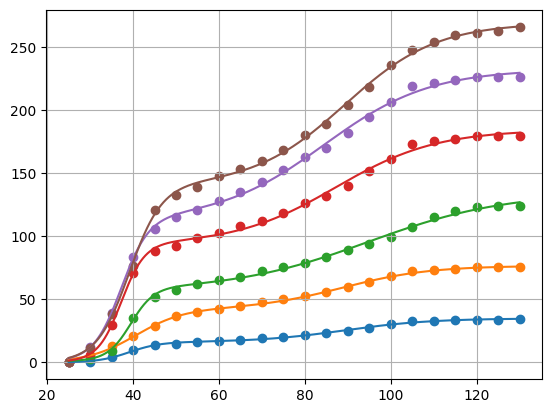

In [19]:
fig, axe = plt.subplots()
for result in results:
    axe.scatter(result["x"], result["y"])
    axe.plot(result["xlin"], result["ylin"])
axe.grid()

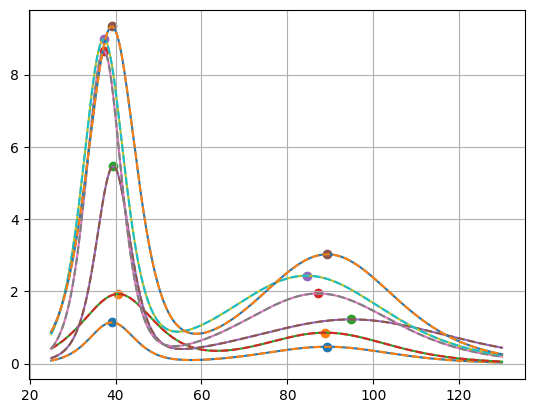

In [21]:
fig, axe = plt.subplots()
for result in results:
    axe.plot(result["xlin"], result["dylin"])
    axe.scatter(result["xpeak"], result["ypeak"])
    axe.plot(result["xlin"], result["fit"], "--")
axe.grid()

In [22]:
results[0]

{'x': array([ 25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,
         90,  95, 100, 105, 110, 115, 120, 125, 130]),
 'y': array([ 0.      ,  0.50031 ,  4.00248 ,  9.50589 , 13.50837 , 15.0093  ,
        16.00992 , 17.01054 , 18.01116 , 19.01178 , 20.51271 , 21.51333 ,
        23.01426 , 25.0155  , 27.51705 , 30.51891 , 32.52015 , 33.270615,
        33.770925, 33.770925, 34.02108 , 34.271235]),
 'popt': array([16.01034057, 39.11907074,  0.28171517, 18.91685719, 89.23311542,
         0.09889412]),
 'pcov': array([[ 3.27376294e-01,  1.61857709e-01, -1.01325368e-02,
         -4.48504871e-01,  3.12322886e-01,  4.50007060e-03],
        [ 1.61857709e-01,  2.22290164e-01, -5.16434339e-03,
         -2.08047587e-01,  1.69691313e-01,  1.86608899e-03],
        [-1.01325368e-02, -5.16434339e-03,  1.00663242e-03,
          1.31831751e-02, -1.03031400e-02, -1.19996705e-04],
        [-4.48504871e-01, -2.08047587e-01,  1.31831751e-02,
          7.79147558e-01, -1.71318041e-01, -7.93615